In [5]:
import pandas as pd
import numpy as np

df_sans_doublons = pd.read_csv('../dataSansDoublons.csv')
df_binaire = pd.read_csv('../dataBinaire.csv')
df_log_transforme = pd.read_csv('../dataLogTransforme.csv')

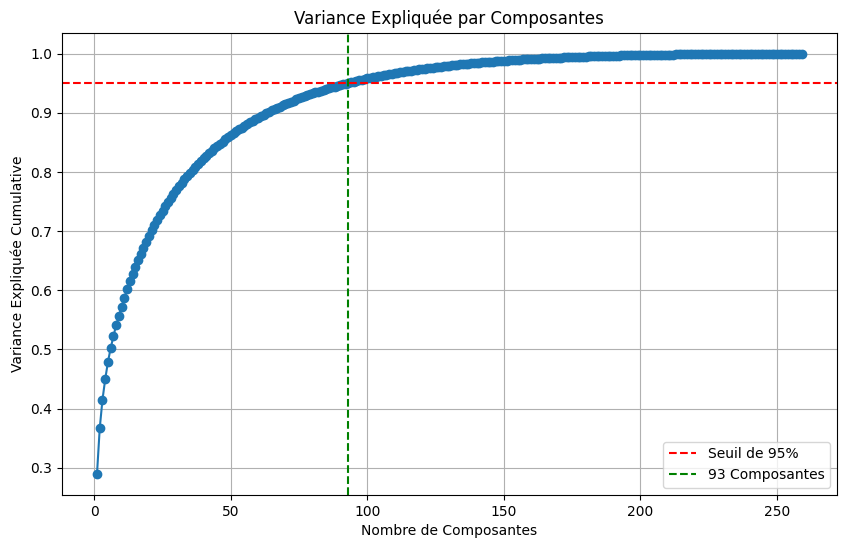

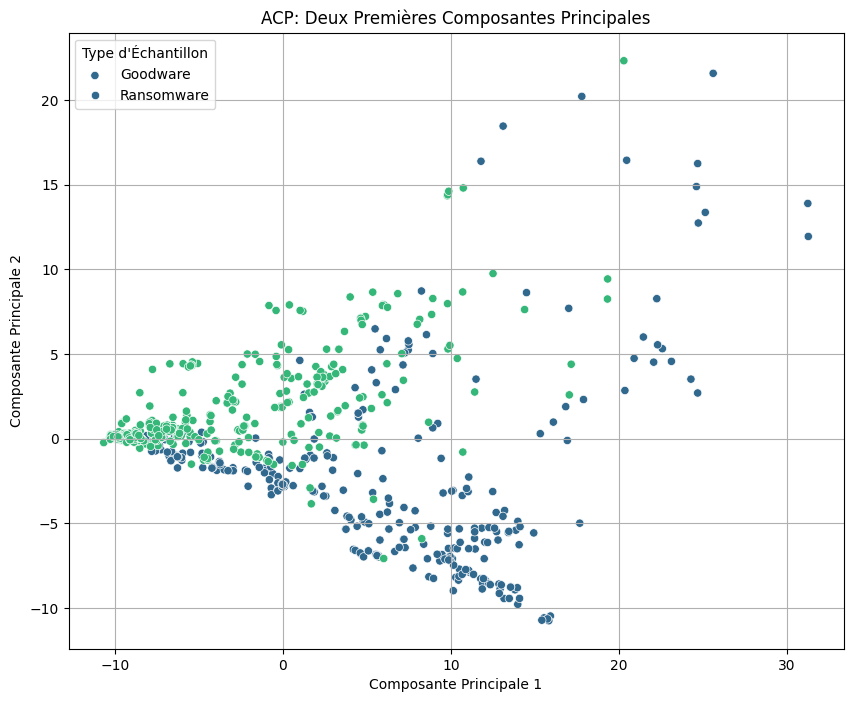


Top 10 variables pour PC1:
CoInitializeEx          0.104313
CoUninitialize          0.102391
CoCreateInstance        0.101489
RegCloseKey             0.101058
RegOpenKeyExW           0.100579
NtMapViewOfSection      0.099732
SHGetFolderPathW        0.098807
NtQueryValueKey         0.098804
NtOpenSection           0.098537
NtUnmapViewOfSection    0.098350
Name: PC1, dtype: float64

Top 10 variables pour PC2:
HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Internet Settings\    0.142504
activite_reseau                                                                   0.137996
NtDeviceIoControlFile                                                             0.134943
getaddrinfo                                                                       0.130779
InternetCloseHandle                                                               0.129603
GetAdaptersAddresses                                                              0.125125
OpenSCManagerA                            

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

# Import necessary libraries
import matplotlib.pyplot as plt

# Extraction des caractéristiques
X = df_log_transforme.drop('Sample_Type', axis=1)
y = df_log_transforme['Sample_Type']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calcul de la variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Nombre de composantes pour 95% de variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Graphique de la variance expliquée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulative')
plt.title('Variance Expliquée par Composantes')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil de 95%')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Composantes')
plt.legend()
plt.grid(True)
plt.show()

# ACP avec composantes optimales
pca_optimal = PCA(n_components=n_components_95)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# DataFrame avec composantes principales
pca_df = pd.DataFrame(
    data=X_pca_optimal, 
    columns=[f'PC{i+1}' for i in range(n_components_95)]
)
pca_df['Sample_Type'] = y

# Visualisation des deux premières composantes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sample_Type', palette='viridis')
plt.title('ACP: Deux Premières Composantes Principales')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Type d\'Échantillon', labels=['Goodware', 'Ransomware'])
plt.grid(True)
plt.show()

# Importance des variables (loadings)
loadings = pd.DataFrame(
    pca_optimal.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=X.columns
)

# Affichage des principales variables pour 3 composantes
n_top_features = 10
for i in range(min(3, n_components_95)):
    pc = f'PC{i+1}'
    print(f"\nTop {n_top_features} variables pour {pc}:")
    top_features = loadings[pc].abs().sort_values(ascending=False).head(n_top_features)
    print(top_features)

print(f"\nL'ACP a réduit les dimensions de {X.shape[1]} à {n_components_95} composantes")
print(f"Variance expliquée avec {n_components_95} composantes: {cumulative_variance[n_components_95-1]:.2%}")

Meilleur k: 1
Précision: 0.9110

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        72
           1       0.91      0.92      0.91        74

    accuracy                           0.91       146
   macro avg       0.91      0.91      0.91       146
weighted avg       0.91      0.91      0.91       146



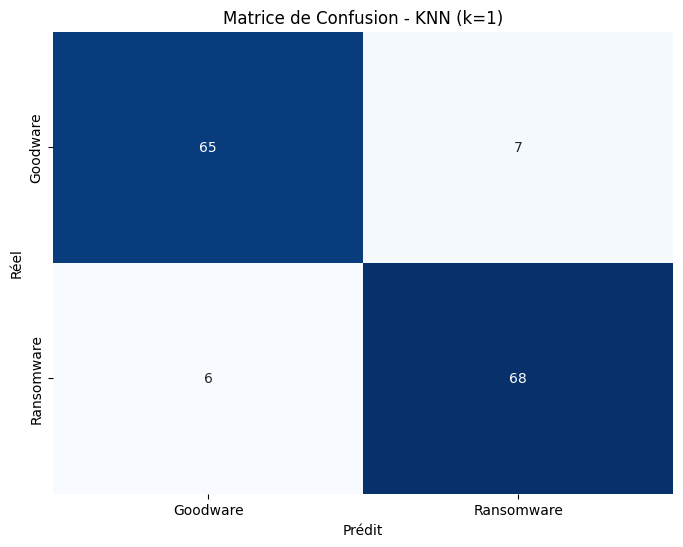

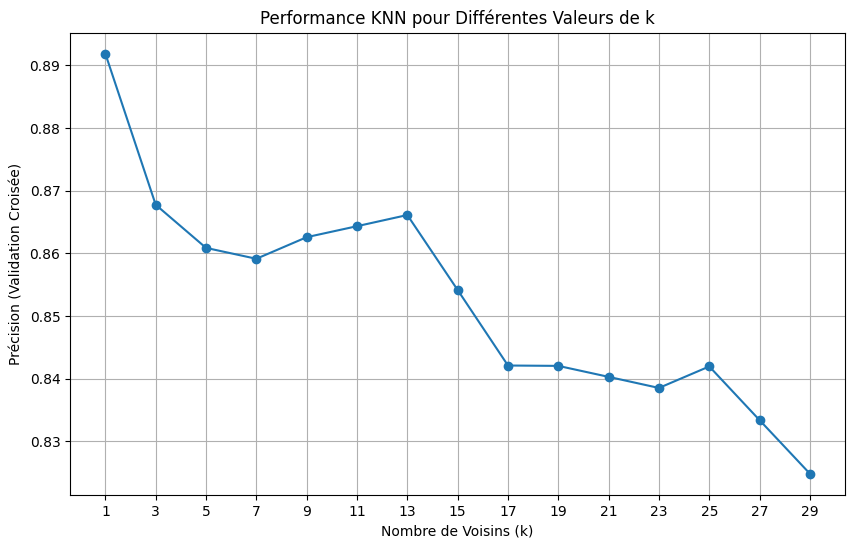

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


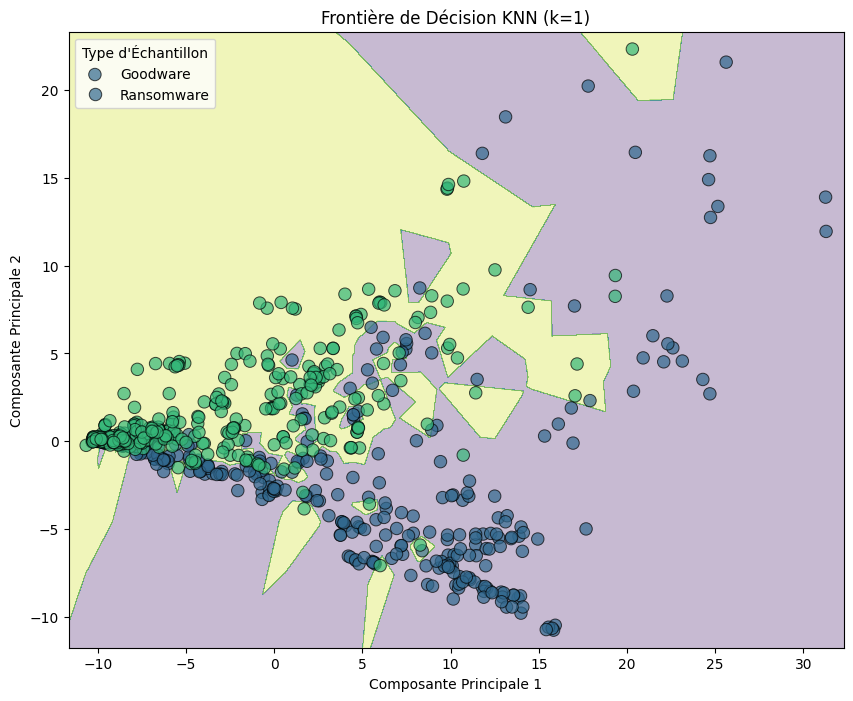

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Extraction des caractéristiques et cible
X = pca_df.drop('Sample_Type', axis=1)
y = pca_df['Sample_Type']

# Division des données (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Recherche du meilleur k
grille_params = {'n_neighbors': range(1, 31, 2)}
knn_cv = GridSearchCV(KNeighborsClassifier(), grille_params, cv=5, scoring='accuracy')
knn_cv.fit(X_train, y_train)

# Meilleur k
meilleur_k = knn_cv.best_params_['n_neighbors']
print(f"Meilleur k: {meilleur_k}")

# Entraînement avec k optimal
knn = KNeighborsClassifier(n_neighbors=meilleur_k)
knn.fit(X_train, y_train)

# Prédiction
y_pred = knn.predict(X_test)

# Évaluation
precision = accuracy_score(y_test, y_pred)
print(f"Précision: {precision:.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Goodware', 'Ransomware'],
            yticklabels=['Goodware', 'Ransomware'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - KNN (k={meilleur_k})')
plt.show()

# Précision pour différentes valeurs de k
k_range = range(1, 31, 2)
k_scores = [knn_cv.cv_results_['mean_test_score'][i] for i in range(len(k_range))]
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Nombre de Voisins (k)')
plt.ylabel('Précision (Validation Croisée)')
plt.title('Performance KNN pour Différentes Valeurs de k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Frontière de décision (PC1 et PC2)
plt.figure(figsize=(10, 8))
h = 0.02
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
knn_simple = KNeighborsClassifier(n_neighbors=meilleur_k)
knn_simple.fit(X_train[['PC1', 'PC2']], y_train)
Z = knn_simple.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sample_Type', palette='viridis', 
                edgecolor='k', s=80, alpha=0.7)
plt.title(f'Frontière de Décision KNN (k={meilleur_k})')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Type d\'Échantillon', labels=['Goodware', 'Ransomware'])
plt.show()


=== Naive Bayes Gaussien ===
Précision: 0.7260
Temps d'entraînement: 0.0047 secondes
Temps de prédiction: 0.0018 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.66      0.92      0.77        72
           1       0.87      0.54      0.67        74

    accuracy                           0.73       146
   macro avg       0.76      0.73      0.72       146
weighted avg       0.77      0.73      0.72       146


=== Naive Bayes Bernoulli ===
Précision: 0.8014
Temps d'entraînement: 0.0036 secondes
Temps de prédiction: 0.0015 secondes

Rapport de classification:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        72
           1       0.78      0.85      0.81        74

    accuracy                           0.80       146
   macro avg       0.80      0.80      0.80       146
weighted avg       0.80      0.80      0.80       146



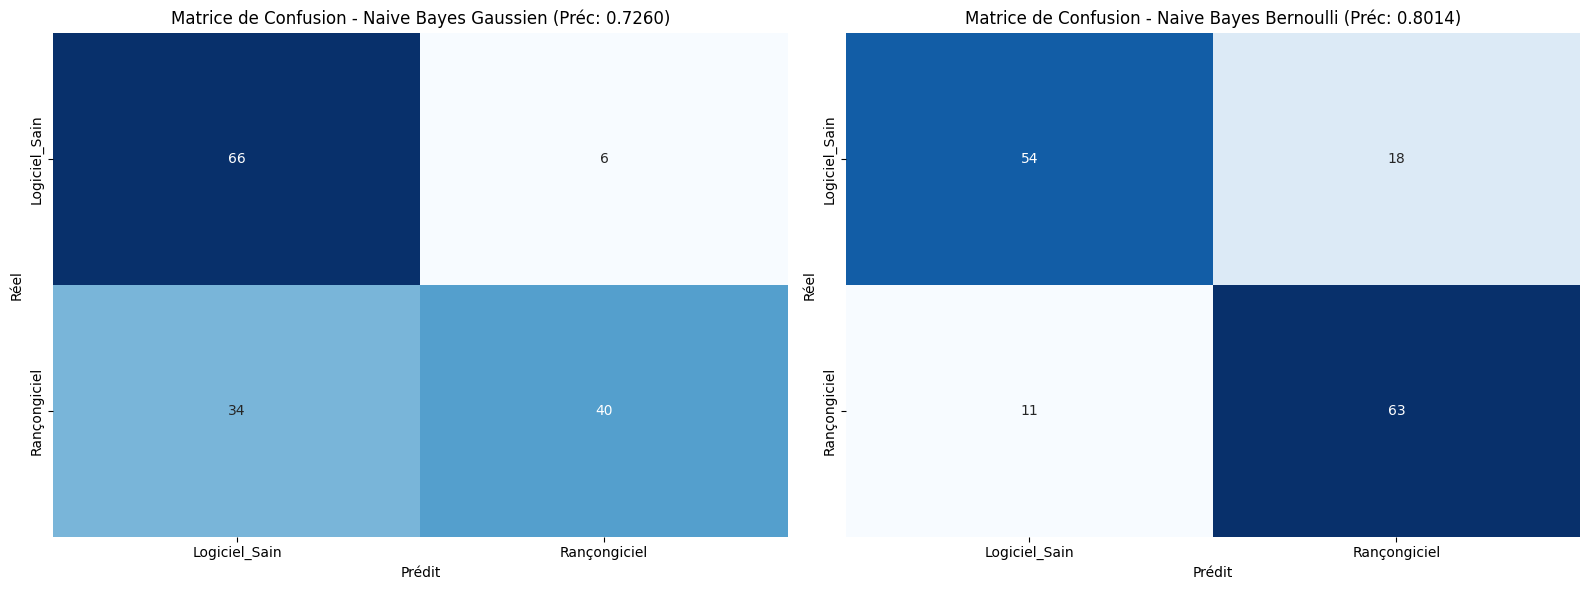

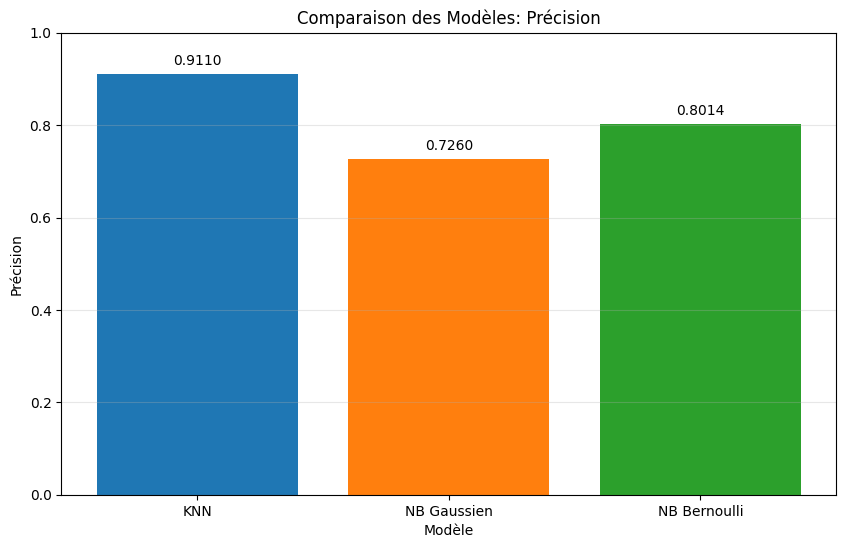

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


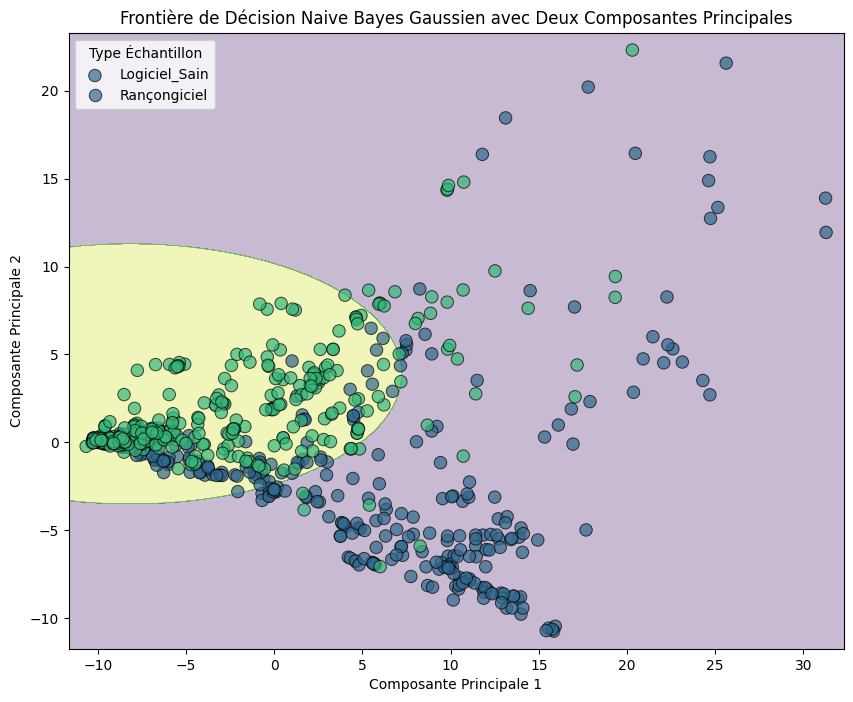

In [12]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import time

import matplotlib.pyplot as plt

# Créer et entraîner modèle Naive Bayes Gaussien
gnb = GaussianNB()
temps_debut = time.time()
gnb.fit(X_train, y_train)
temps_entrainement_gnb = time.time() - temps_debut

# Créer et entraîner modèle Naive Bayes Bernoulli
bnb = BernoulliNB()
temps_debut = time.time()
bnb.fit(X_train, y_train)
temps_entrainement_bnb = time.time() - temps_debut

# Faire prédictions
temps_debut = time.time()
gnb_y_pred = gnb.predict(X_test)
temps_prediction_gnb = time.time() - temps_debut

temps_debut = time.time()
bnb_y_pred = bnb.predict(X_test)
temps_prediction_bnb = time.time() - temps_debut

# Évaluer modèles
precision_gnb = accuracy_score(y_test, gnb_y_pred)
precision_bnb = accuracy_score(y_test, bnb_y_pred)

# Afficher résultats
print("=== Naive Bayes Gaussien ===")
print(f"Précision: {precision_gnb:.4f}")
print(f"Temps d'entraînement: {temps_entrainement_gnb:.4f} secondes")
print(f"Temps de prédiction: {temps_prediction_gnb:.4f} secondes")
print("\nRapport de classification:")
print(classification_report(y_test, gnb_y_pred))

print("\n=== Naive Bayes Bernoulli ===")
print(f"Précision: {precision_bnb:.4f}")
print(f"Temps d'entraînement: {temps_entrainement_bnb:.4f} secondes")
print(f"Temps de prédiction: {temps_prediction_bnb:.4f} secondes")
print("\nRapport de classification:")
print(classification_report(y_test, bnb_y_pred))

# Créer matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion GNB
matrice_confusion_gnb = confusion_matrix(y_test, gnb_y_pred)
sns.heatmap(matrice_confusion_gnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Logiciel_Sain', 'Rançongiciel'],
            yticklabels=['Logiciel_Sain', 'Rançongiciel'], ax=axes[0])
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')
axes[0].set_title(f'Matrice de Confusion - Naive Bayes Gaussien (Préc: {precision_gnb:.4f})')

# Matrice de confusion BNB
matrice_confusion_bnb = confusion_matrix(y_test, bnb_y_pred)
sns.heatmap(matrice_confusion_bnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Logiciel_Sain', 'Rançongiciel'],
            yticklabels=['Logiciel_Sain', 'Rançongiciel'], ax=axes[1])
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Réel')
axes[1].set_title(f'Matrice de Confusion - Naive Bayes Bernoulli (Préc: {precision_bnb:.4f})')

plt.tight_layout()
plt.show()

# Comparer avec KNN
modeles = ['KNN', 'NB Gaussien', 'NB Bernoulli']
precisions = [accuracy_score(y_test, y_pred), precision_gnb, precision_bnb]

plt.figure(figsize=(10, 6))
plt.bar(modeles, precisions, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylim(0, 1)
plt.xlabel('Modèle')
plt.ylabel('Précision')
plt.title('Comparaison des Modèles: Précision')
for i, acc in enumerate(precisions):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visualiser frontières de décision pour GNB (avec PC1 et PC2)
plt.figure(figsize=(10, 8))
# Créer maillage
h = 0.02  # Pas dans le maillage
x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Créer modèle GNB simplifié avec 2 PCs pour visualisation
gnb_simple = GaussianNB()
gnb_simple.fit(X_train[['PC1', 'PC2']], y_train)

# Tracer frontière de décision
Z = gnb_simple.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Tracer points d'entraînement
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sample_Type', palette='viridis', 
                edgecolor='k', s=80, alpha=0.7)
plt.title('Frontière de Décision Naive Bayes Gaussien avec Deux Composantes Principales')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Type Échantillon', labels=['Logiciel_Sain', 'Rançongiciel'])
plt.show()